In [ ]:
# plot composites of storm characteristics
# Fig. 3 in paper

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath_aux     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'composites_FIXED_DUPLICATES/'
# check existence of paths
if not os.path.exists(savepath_aux):
    print ('Created '+savepath_aux)
    os.makedirs(savepath_aux)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [3]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    
def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                        data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
                
    return data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm

def load_data(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    return data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux



-------
Plot  PAR_incoming 
-------



/tmp/ipykernel_171319/1476137038.py:129: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_171319/1476137038.py:392: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_171319/1476137038.py:411: RuntimeWarning: Mean of empty slice
  data0 = np.nanmean(np.nanmean(data_aux_mean_lr_all,axis=2),axis=1)
/tmp/ipykernel_171319/1476137038.py:412: RuntimeWarning: Mean of empty slice
  data1 = np.nanmean(np.nanmean(data_aux_mean_lr1,axis=2),axis=1)
/tmp/ipykernel_171319/1476137038.py:413: RuntimeWarning: Mean of empty slice
  data2 = np.nanmean(np.nanmean(data_aux_mean_lr2,axis=2),axis=1)


data_storm.shape (9615, 21, 21)
data_storm_chl.shape (9615, 21, 21)

Only consider storms with data in LOW RES full in analysis...
BEFORE kicking out NaNs: data_storm.shape (9615, 21, 21)
AFTER kicking out NaNs: data_storm.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_abs.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_chl.shape (9554, 21, 21)
identify the strongest storms based on LOW RES full field...
thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

LOW RES
Number of storms with data: 9554 956 956
Size of arrays: (9554, 21, 21) (956, 21, 21) (956, 21, 21)


100%|██████████| 22/22 [00:01<00:00, 20.20it/s]
/tmp/ipykernel_171319/1476137038.py:521: RuntimeWarning: Mean of empty slice
  data_storms_0 = np.nanmean(data_aux_mean_lr_all,axis=0) # ALL
/tmp/ipykernel_171319/1476137038.py:522: RuntimeWarning: Mean of empty slice
  data_storms_1 = np.nanmean(data_aux_mean_lr1,axis=0) # strongest negative anomaly
/tmp/ipykernel_171319/1476137038.py:523: RuntimeWarning: Mean of empty slice
  data_storms_2 = np.nanmean(data_aux_mean_lr2,axis=0) # strongest positive anomaly
/tmp/ipykernel_171319/1476137038.py:524: RuntimeWarning: Mean of empty slice
  data_storms_0_abs = np.nanmean(data_aux_mean_lr_all_abs,axis=0) # ALL
/tmp/ipykernel_171319/1476137038.py:525: RuntimeWarning: Mean of empty slice
  data_storms_1_abs = np.nanmean(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
/tmp/ipykernel_171319/1476137038.py:526: RuntimeWarning: Mean of empty slice
  data_storms_2_abs = np.nanmean(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly
/g

(12, 21, 21) 0.5347593426704407 99.3670883178711
(12, 21, 21) 0.4651162922382355 95.03546142578125
(12, 21, 21) 0.5076141953468323 95.38461303710938
LOW RES...
data_aux_mean_lr_all.shape (9554, 21, 21)


/tmp/ipykernel_171319/1476137038.py:536: RuntimeWarning: Mean of empty slice
  data_stippling = np.nanmean(data_count_all_rel,axis=0)
/tmp/ipykernel_171319/1476137038.py:537: RuntimeWarning: Mean of empty slice
  data_stippling_pos = np.nanmean(data_count_all_rel_pos,axis=0)
/tmp/ipykernel_171319/1476137038.py:538: RuntimeWarning: Mean of empty slice
  data_stippling_neg = np.nanmean(data_count_all_rel_neg,axis=0)


MEAN of all storms LOW RES, full, avg: -2.0604668
MIN of all storms LOW RES, full, avg: -12.787624
MAX of all storms LOW RES, full, avg: 5.345904


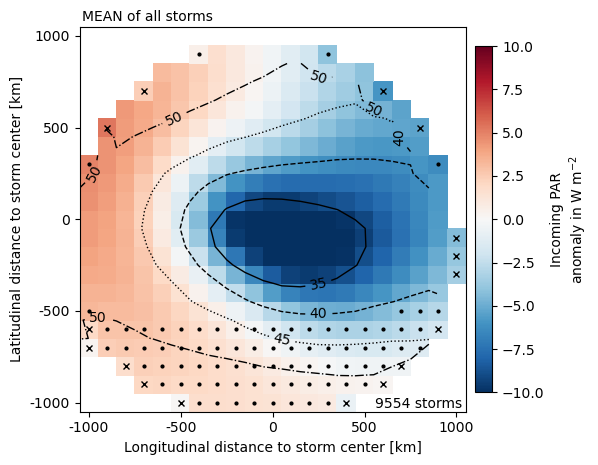

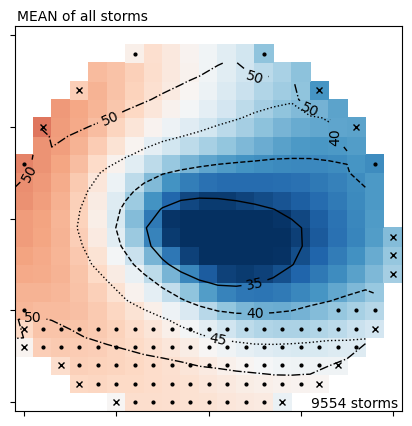

/tmp/ipykernel_171319/1476137038.py:369: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['']*len(cticks))


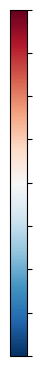

MEAN of all storms LOW RES absolute, full, avg: 45.73152


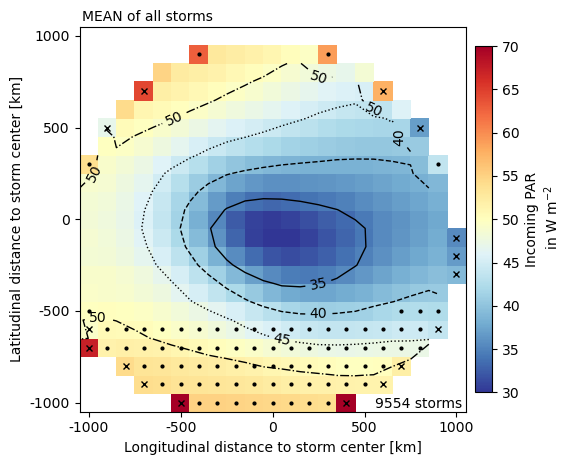

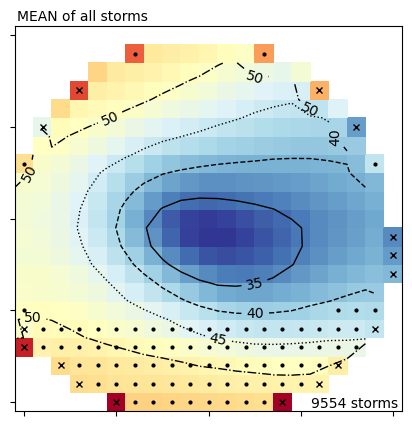

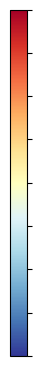


-------
Plot  wind_speed 
-------

data_storm.shape (9615, 21, 21)
data_storm_chl.shape (9615, 21, 21)

Only consider storms with data in LOW RES full in analysis...
BEFORE kicking out NaNs: data_storm.shape (9615, 21, 21)
AFTER kicking out NaNs: data_storm.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_abs.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_chl.shape (9554, 21, 21)
identify the strongest storms based on LOW RES full field...
thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

LOW RES
Number of storms with data: 9554 956 956
Size of arrays: (9554, 21, 21) (956, 21, 21) (956, 21, 21)


100%|██████████| 22/22 [00:00<00:00, 97.04it/s] 


(12, 21, 21) 0.5347593426704407 99.3670883178711
(12, 21, 21) 0.4651162922382355 95.03546142578125
(12, 21, 21) 0.5076141953468323 95.38461303710938
LOW RES...
data_aux_mean_lr_all.shape (9554, 21, 21)
MEAN of all storms LOW RES, full, avg: 0.559871
MIN of all storms LOW RES, full, avg: -0.80641985
MAX of all storms LOW RES, full, avg: 2.817801


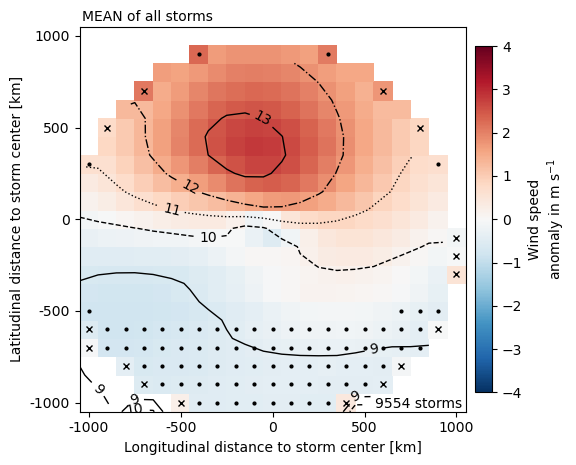

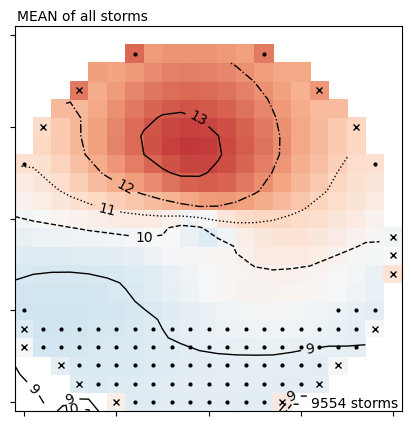

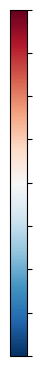

MEAN of all storms LOW RES absolute, full, avg: 10.322465


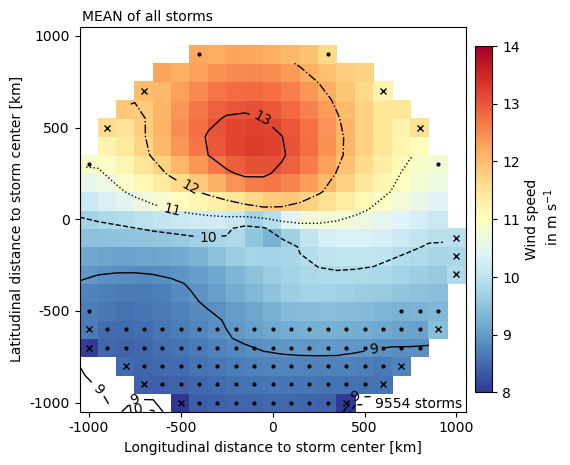

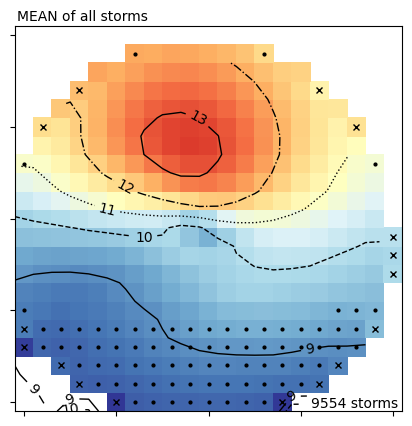

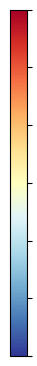


-------
Plot  slp 
-------

data_storm.shape (9615, 21, 21)
data_storm_chl.shape (9615, 21, 21)

Only consider storms with data in LOW RES full in analysis...
BEFORE kicking out NaNs: data_storm.shape (9615, 21, 21)
AFTER kicking out NaNs: data_storm.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_abs.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_chl.shape (9554, 21, 21)
identify the strongest storms based on LOW RES full field...
thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

LOW RES
Number of storms with data: 9554 956 956
Size of arrays: (9554, 21, 21) (956, 21, 21) (956, 21, 21)


100%|██████████| 22/22 [00:00<00:00, 103.08it/s]


(12, 21, 21) 0.5347593426704407 99.3670883178711
(12, 21, 21) 0.4651162922382355 95.03546142578125
(12, 21, 21) 0.5076141953468323 95.38461303710938
LOW RES...
data_aux_mean_lr_all.shape (9554, 21, 21)
MEAN of all storms LOW RES, full, avg: -5.1794324
MIN of all storms LOW RES, full, avg: -13.924395
MAX of all storms LOW RES, full, avg: 2.9970903


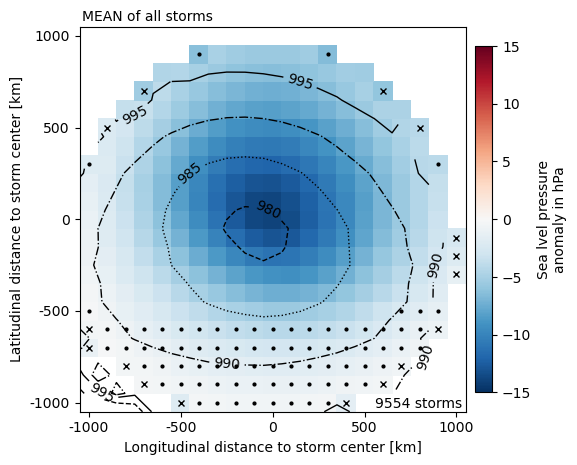

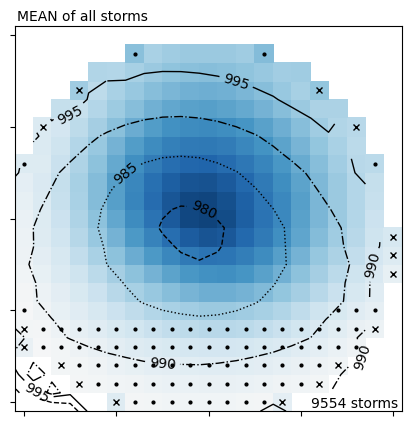

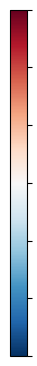

MEAN of all storms LOW RES absolute, full, avg: 989.24756


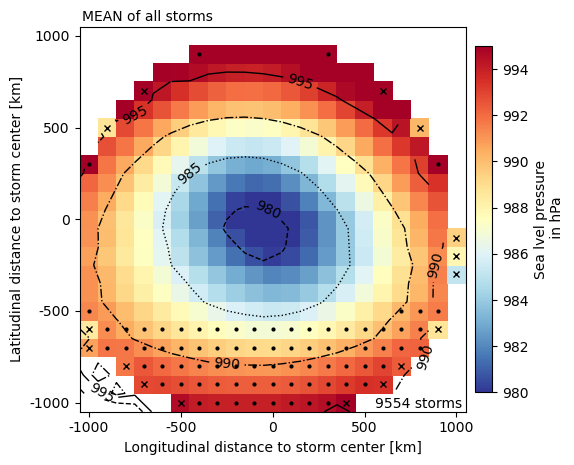

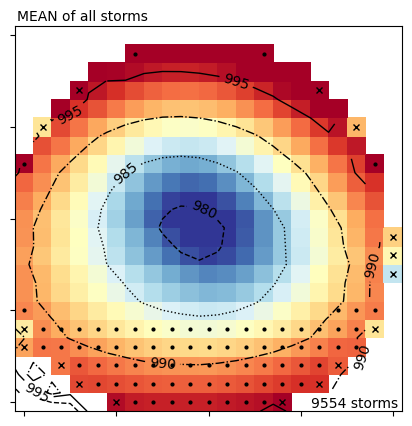

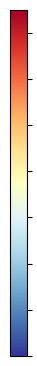

done  


In [4]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

year_list = np.arange(1997,2018+1,1)

save_plots    = False
display_plots = True    
display_plots_aux = True # emulator, HR
display_plots_monthly = False
plot_monthly = False

# vari_list & time_string_list must have the same number of entries!
#
# for shifted times: make sure to select the exact same storms as for the day of storm passing!!! 
# --> TESTING in another script, then adapt the code here!
#
vari_list = ['PAR_incoming','wind_speed','slp'] #, 'photoC_total_surf'\
           # 'totChl','mu_diat','mu_sp','MLD','wind_speed','PAR_incoming',\
           # 'photoC_total_surf','photoC_zint','phytoC_zint_100m',\
           # 'totChl','mu_diat','mu_sp','MLD','wind_speed','PAR_incoming',\
           # 'photoC_total_surf','photoC_zint','phytoC_zint_100m']
time_string_list = ['','',''] #,'',\
            #       '_plus_2_days','_plus_2_days','_plus_2_days','_plus_2_days','_plus_2_days','_plus_2_days',\
            #       '_plus_2_days','_plus_2_days','_plus_2_days',\
            #       '_minus_2_days','_minus_2_days','_minus_2_days','_minus_2_days','_minus_2_days','_minus_2_days',\
            #       '_minus_2_days','_minus_2_days','_minus_2_days']

perc1 = 10 #25
perc2 = 90 #75

for vv in range(0,len(vari_list)):
    vari = vari_list[vv]
    time_string = time_string_list[vv]
    print()
    print('-------')
    print('Plot ',vari,time_string)
    print('-------')
    print()

    # where are data
    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
    path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
    path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'

    # if vari is not totChl, provide path to totChl (LOW RES, full & emulator) here --> files need to be loaded so that strongest storms can be identified correctly
    path_chl    = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_anomalies/'
    path_chl_em = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_emulator_anomalies/'

    if time_string=='':
        savepath = savepath_aux+vari+'/'
    else:
        savepath = savepath_aux+vari+'/'+time_string+'/'
    # check existence of paths
    if not os.path.exists(savepath):
        print ('Created '+savepath)
        os.makedirs(savepath)
        
    # eps
    savepath2 = savepath+'eps/'
    # check existence of paths
    if not os.path.exists(savepath2):
        print ('Created '+savepath2)
        os.makedirs(savepath2)
    
    #----
    # LOW RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
    file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

    # load data
    data_storm,month_storm,lat_storm,\
                lon_storm,slp_avg_storm,slp_min_storm = load_data(path1,file1,vari+'_storm_anomaly4_mean')

    #---
    # ABS
    #---
    # load data
    data_storm_abs,month_storm_abs,lat_storm_abs,\
                lon_storm_abs,slp_avg_storm_abs,slp_min_storm_abs = load_data(path1,file1b,vari+'_storm_mean')

        
    # if I chose a different variable above, load totChl of LOW RES anyway (full + emulator)
    #   (for determining storms with strongest impact)
    #
    # NOTE: always load data on day of storm passing here! This is the basis for determining the strongest storms.
    #
    if (not vari=='totChl') | (not time_string==''): 
        #----
        # LOW RES, FULL FIELD, anomalies only (only needed to determine strongest storms)
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'

        # load data
        data_storm_chl,month_storm_chl,lat_storm_chl,\
                     lon_storm_chl,slp_avg_storm_chl,slp_min_storm_chl = load_data(path_chl,file1,'totChl_storm_anomaly4_mean')
        
    
    print('data_storm.shape',data_storm.shape)
    if (not vari=='totChl') | (not time_string==''): 
        print('data_storm_chl.shape',data_storm_chl.shape)

    #---
    # only consider storms that have data in LOW RES full (correct arrays here)
    #---
    print()
    print('Only consider storms with data in LOW RES full in analysis...')

    # what is the array called that contains totChl (LOW RES full)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else: # if BEFORE/AFTER is chosen, always use "chl on day of storm passing" here (--> basis for selction of strong storms)
        data_aux    = np.copy(data_storm_chl)

    # find storms of interest based on chl anomalies
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]

    print('BEFORE kicking out NaNs: data_storm.shape',data_storm.shape)
    data_storm  = data_storm[ind_no_NaN,:,:]
    month_storm = month_storm[ind_no_NaN]
    lat_storm   = lat_storm[ind_no_NaN]
    lon_storm   = lon_storm[ind_no_NaN]
    slp_avg_storm = slp_avg_storm[ind_no_NaN]
    slp_min_storm = slp_min_storm[ind_no_NaN]
    data_storm_abs = data_storm_abs[ind_no_NaN,:,:]
    print('AFTER kicking out NaNs: data_storm.shape',data_storm.shape)
    print('AFTER kicking out NaNs: data_storm_abs.shape',data_storm_abs.shape)
    if (not vari=='totChl') | (not time_string==''): 
        data_storm_chl  = data_storm_chl[ind_no_NaN,:,:]
        print('AFTER kicking out NaNs: data_storm_chl.shape',data_storm_chl.shape)
        
    #---
    # settings for plotting
    #---

    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    if vari=='totChl':
        v1,v2   = -0.1,0.1 # MEAN
        v1b,v2b = -0.03,0.03 # MEDIAN
        contours_abs = [0.05,0.1,0.2,0.4,0.6,0.8,1]
        factor  = 1
        cbar_label = 'Surface chlorophyll\nanomaly in mg m$^{-3}$'
    elif vari=='MLD':
        v1,v2   = -10,10 # MEAN
        v1b,v2b = -5,5 # MEDIAN
        contours_abs = [40,60,80,100,120,140,160]
        factor  = 0.01 # convert from cm to m
        cbar_label = 'MLD\nanomaly in m'
    elif vari=='PAR_incoming':
        v1,v2   = -10,10 #-20,20 # MEAN
        v1b,v2b = -10,10 #-20,20 # MEDIAN
        v1_abs,v2_abs = 30,70
        contours_abs = [35,40,45,50] #[40,60,80,100,120,140,160]
        factor  = 1
        cbar_label = 'Incoming PAR\nanomaly in W m$^{-2}$'
        cbar_label_abs = 'Incoming PAR\n in W m$^{-2}$'
    elif vari=='wind_speed':
        v1,v2   = -4,4 # MEAN
        v1b,v2b = -4,4 # MEDIAN
        v1_abs,v2_abs = 8,14
        contours_abs = [9,10,11,12,13]
        factor  = 1
        cbar_label = 'Wind speed\nanomaly in m s$^{-1}$'
        cbar_label_abs = 'Wind speed\n in m s$^{-1}$'
    elif vari=='mu_diat':
        v1,v2   = -0.05,0.05 # MEAN
        v1b,v2b = -0.03,0.03  # MEDIAN
        contours_abs = [0.1,0.2,0.3,0.4,0.5,0.6]
        factor  = 1
        cbar_label = 'Diatom growth rate\nanomaly in d$^{-1}$'
    elif vari=='mu_sp':
        v1,v2   = -0.05,0.05 # MEAN
        v1b,v2b = -0.03,0.03  # MEDIAN
        contours_abs = [0.1,0.2,0.3,0.4,0.5,0.6]
        factor     = 1
        cbar_label = 'SP growth rate\nanomaly in d$^{-1}$'
    elif vari=='phytoC_zint_100m':
        v1,v2   = -1,1 # MEAN
        v1b,v2b = -1,1  # MEDIAN
        contours_abs = [1,5,10,15]
        factor       = 0.001 # convert from mmol to mol
        cbar_label   = 'Integrated phytoC biomass\nanomaly in mol C m$^{-2}$'
    elif vari=='photoC_total_surf':
        v1,v2   = -0.002,0.002
        v1b,v2b = -0.002,0.002
        factor  = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
        contours_abs = [0.001,0.007,0.01,0.015]
        cbar_label   = 'Surface NPP\nanomaly in mmol m$^{-2}$ d$^{-1}$'
    elif vari=='photoC_zint':
        v1,v2   = -5,5
        v1b,v2b = -5,5
        factor = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
        contours_abs = [2,15,25,35] #[20,30,40]
        cbar_label  = 'Vertically integrated NPP\nanomaly in mmol m$^{-2}$ d$^{-1}$'
    elif vari=='slp':
        v1,v2   = -15,15
        v1b,v2b = -15,15
        v1_abs,v2_abs = 980,995
        factor = 0.01 # convert from Pa to hPa
        contours_abs = [975,980,985,990,995,1005] #[945,955,965,975,985,995,1005] #[20,30,40]
        cbar_label  = 'Sea lvel pressure\nanomaly in hPa'
        cbar_label_abs  = 'Sea lvel pressure\n in hPa'

    # for strongest storms, adjust limits
    if (perc1==10) & (perc2==90): 
        if vari=='totChl':
            v1,v2   = v1,v2 #0.25*v1,0.25*v2 #2*v1,2*v2
            v1b,v2b = v1,v2
        else:
            if vari=='slp':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='wind_speed':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='PAR_incoming':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            else:
                v1,v2   = 2*v1,2*v2
                v1b,v2b = 2*v1b,2*v2b

    def plot_composite(data_plot,data_plot_abs,data_stippling,thrsh_list,v1,v2,contours_abs,\
                       cbar_label,num_storms,label_string,time_string,save_plots,display_plots,savepath,filename):

        if filename[-12:-4]=='ABSOLUTE':
            cmap1  = plt.cm.RdYlBu_r
        else:
            cmap1  = plt.cm.RdBu_r
        fs     = 10
        dpicnt = 150
        lw = 1
        if contours_abs[0]<1:
            if contours_abs[0]<0.1:
                format_labels = "%1.3f"
            else:
                format_labels = "%1.2f"
        else:
            format_labels = "%d"

        res    = 100
        x_bins = np.arange(-1000,1000+res,res)
        y_bins = np.arange(-1000,1000+res,res)
        xticks = np.arange(0,len(x_bins))
        xticks = [(x+0.5) for x in xticks]

        plot_abs = False
        if plot_abs:
            fig = plt.figure(figsize=(6,5))
            plt.pcolor(data_plot_abs.transpose(),cmap=plt.cm.RdYlBu_r,vmin=0,vmax=0.4)
            plt.colorbar()
            plt.show()

        add_stippling = True
        
        data_plot[np.isnan(data_stippling)] = np.nan

        fig = plt.figure(figsize=(6,5))
        m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
        cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
        cbar.set_label(cbar_label,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
        cticks = cbar.ax.get_yticklabels()
        plt.xticks(xticks[0::5],x_bins[0::5])
        plt.yticks(xticks[0::5],y_bins[0::5])
        plt.ylabel('Latitudinal distance to storm center [km]',fontsize=fs)
        plt.xlabel('Longitudinal distance to storm center [km]',fontsize=fs)
        plt.annotate(label_string,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs,ha='left') 
        plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
        CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                    linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
        try:
            CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
        except:
            pass

        if add_stippling:
            #data_stippling = np.copy(data_count_all_rel)[mm,:,:]
            # add stippling for locations with value below XX%
            threshold1 = thrsh_list[0] #25
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if data_stippling.transpose()[xx,yy]<=threshold1:
                        plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                        #plt.plot(yy+0.5,xx+0.5,'ko',markerfacecolor='none',markersize=4,linewidth=1)
            threshold2 = thrsh_list[1] #40
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                        plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                        #plt.plot(yy+0.5,xx+0.5,'k.',markersize=1)
        if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days']:
            plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
            plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        if save_plots:
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
            
            
        # EPS
        plot_eps = True
        if plot_eps:
            fig = plt.figure(figsize=(5,5))
            m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
            #cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
            #cbar.set_label(cbar_label,fontsize=fs)
            #cbar.ax.tick_params(labelsize=fs)
            plt.xticks(xticks[0::5],[])
            plt.yticks(xticks[0::5],[])
            plt.annotate(label_string,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs,ha='left') 
            plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
            CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                        linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
            try:
                CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
            except:
                pass
            if add_stippling:
                # add stippling for locations with value below XX%
                threshold1 = thrsh_list[0] #25
                for xx in range(0,len(xticks)):
                    for yy in range(0,len(xticks)):
                        if data_stippling.transpose()[xx,yy]<=threshold1:
                            plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                            #plt.plot(yy+0.5,xx+0.5,'ko',markerfacecolor='none',markersize=4,linewidth=1)
                threshold2 = thrsh_list[1] #40
                for xx in range(0,len(xticks)):
                    for yy in range(0,len(xticks)):
                        if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                            plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                            #plt.plot(yy+0.5,xx+0.5,'k.',markersize=1)
            if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days']:
                plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
            elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
                plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
            if save_plots:
                plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            if display_plots:
                plt.show()
            else:
                plt.close(fig)
                
            # COLORABR
            fig = plt.figure(figsize=(5,5))
            m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
            plt.gca().set_visible(False)
            cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
            #cbar.set_label(cbar_label,fontsize=fs)
            cbar.ax.tick_params(labelsize=fs)
            cbar.ax.set_yticklabels(['']*len(cticks))
            if save_plots:
                plt.savefig(savepath+'eps/'+filename[:-4]+'_colorbar.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            if display_plots:
                plt.show()
            else:
                plt.close(fig)
       
    #----
    # identify the strongest storms based on LOW RES full field
    #----
    print('identify the strongest storms based on LOW RES full field...')

    # what is the array called that contains totChl  to used here (LOW RES full, day of passing)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else:
        data_aux = np.copy(data_storm_chl)

    # determine thresholds for "strong" storms based on LOW RES full field
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
    thrsh1 = np.percentile(data_aux_mean[ind_no_NaN],perc1) # XX% with largest negative anomaly
    thrsh2 = np.percentile(data_aux_mean[ind_no_NaN],perc2) # XX% with largest positive anomaly
    ind_strong1_lr = np.where(data_aux_mean[ind_no_NaN]<=thrsh1)[0]
    ind_strong2_lr = np.where(data_aux_mean[ind_no_NaN]>=thrsh2)[0]
    print('thrsh1,thrsh2',thrsh1,thrsh2)

    # reduce the arrays accordingly
    print()
    print('LOW RES')
    # create arrays to plot for LR, emulator & HR
    data_aux_mean_lr_all = data_storm[ind_no_NaN,:,:]
    data_aux_mean_lr1    = data_storm[ind_no_NaN,:,:][ind_strong1_lr,:,:]
    data_aux_mean_lr2    = data_storm[ind_no_NaN,:,:][ind_strong2_lr,:,:]
    data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN,:,:]
    data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
    data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]
    # How many of the remaining storms have data?
    data0 = np.nanmean(np.nanmean(data_aux_mean_lr_all,axis=2),axis=1)
    data1 = np.nanmean(np.nanmean(data_aux_mean_lr1,axis=2),axis=1)
    data2 = np.nanmean(np.nanmean(data_aux_mean_lr2,axis=2),axis=1)
    ind_no_NaN0 = np.where(~np.isnan(data0))[0]
    ind_no_NaN1 = np.where(~np.isnan(data1))[0]
    ind_no_NaN2 = np.where(~np.isnan(data2))[0]
    num_storms_lr  = ind_no_NaN0.shape[0]
    num_storms_lr1 = ind_no_NaN1.shape[0]
    num_storms_lr2 = ind_no_NaN2.shape[0]
    print('Number of storms with data:',num_storms_lr,num_storms_lr1,num_storms_lr2)
    print('Size of arrays:',data_aux_mean_lr_all.shape,data_aux_mean_lr1.shape,data_aux_mean_lr2.shape)
    del data0,data1,data2,ind_no_NaN0,ind_no_NaN1,ind_no_NaN2

    #---
    # load num_obs data for full field to add stippling to anomaly plots
    #---

    dist_threshold = 1000

    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/count_obs_in_anomalies/'

    def load_data_for_stippling(path1,name_string,vari,years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm):

        for yy in tqdm(range(0,len(years))):

            file1 = 'Composite_anomalies_within_'+str(dist_threshold)+'km_of_storm_center_at_noon'+\
                                               '_'+name_string+str(years[yy])+'-01-01_subtract_clim_first_COUNT_OBS.nc'

            # anomaly of vari
            ff  = xr.open_dataset(path1+file1)
            aux_count       = ff[vari+'_storm_anomaly4_count'].values 
            aux_count_max   = ff[vari+'_storm_anomaly4_count_max'].values 
            month_storm     = ff['month_storm'].values  # at min. SLP
            days_storm      = ff['days_storm'].values 
            lon_storm       = ff['lon_storm'].values # at min. SLP
            lat_storm       = ff['lat_storm'].values # at min. SLP
            min_slp         = ff['min_min_slp_storm'].values # Minimum sea level pressure during the existence of each storm (based on min. SLP at noon)
            ff.close()

            if yy==0:
                data_count = aux_count
                data_count_max = aux_count_max
            else:
                data_count     = np.concatenate((data_count,aux_count))
                data_count_max = np.concatenate((data_count_max,aux_count_max))

            del aux_count,aux_count_max

        # only consider storms with data in LOW RES full field
        data_count1    = data_count[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_count2    = data_count[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        data_count_max1    = data_count_max[ind_no_NaN][ind_strong1_lr]
        data_count_max2    = data_count_max[ind_no_NaN][ind_strong2_lr]

        #---
        # get monthly stippling information
        #---

        data_count_all_rel     = np.nan*np.ones([12,21,21])
        data_count_all_rel_pos = np.nan*np.ones([12,21,21])
        data_count_all_rel_neg = np.nan*np.ones([12,21,21])
        for mm in range(0,12):

            # find storms of interest
            ind_storm        = np.where(month_storm==mm+1)[0]

            # all storms
            data_count_all             = np.nansum(data_count[ind_storm],axis=0)
            data_count_all_rel[mm,:,:] = 100*data_count_all/np.nansum(data_count_max[ind_storm])
            del data_count_all

            # strongest storms with neg. chl anomaly
            data_count_all                 = np.nansum(data_count1[ind_storm],axis=0)
            data_count_all_rel_neg[mm,:,:] = 100*data_count_all/np.nansum(data_count_max1[ind_storm])
            del data_count_all

            # strongest storms with pos. chl anomaly
            data_count_all                 = np.nansum(data_count2[ind_storm],axis=0)
            data_count_all_rel_pos[mm,:,:] = 100*data_count_all/np.nansum(data_count_max2[ind_storm])
            del data_count_all

        data_count_all_rel[data_count_all_rel==0] = np.nan
        data_count_all_rel_pos[data_count_all_rel_pos==0] = np.nan
        data_count_all_rel_neg[data_count_all_rel_neg==0] = np.nan

        print(data_count_all_rel.shape,np.nanmin(data_count_all_rel),np.nanmax(data_count_all_rel))
        print(data_count_all_rel_pos.shape,np.nanmin(data_count_all_rel_pos),np.nanmax(data_count_all_rel_pos))
        print(data_count_all_rel_neg.shape,np.nanmin(data_count_all_rel_neg),np.nanmax(data_count_all_rel_neg))

        return data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg


    # LOW RES, full field
    name_string = ''
    vari_obs = 'totChl'
    data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg = load_data_for_stippling(path1,name_string,vari_obs,\
                                        years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

        
    #---
    # MEAN/MEDIAN & STRONGEST STORMS (all months together)
    #---
    #
    # NOTE: for full fields, only include storms that are also included in emulator!!! Else I am not comparing the same things!
    #       I.e., irrespective of what variable is chosen, I always need to load LOW RES full field & emulator to select the correct storms!
    #
    print('LOW RES...')
    print('data_aux_mean_lr_all.shape',data_aux_mean_lr_all.shape)
        
    # MEAN of all storms
    data_storms_0 = np.nanmean(data_aux_mean_lr_all,axis=0) # ALL
    data_storms_1 = np.nanmean(data_aux_mean_lr1,axis=0) # strongest negative anomaly
    data_storms_2 = np.nanmean(data_aux_mean_lr2,axis=0) # strongest positive anomaly
    data_storms_0_abs = np.nanmean(data_aux_mean_lr_all_abs,axis=0) # ALL
    data_storms_1_abs = np.nanmean(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
    data_storms_2_abs = np.nanmean(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly
    # MEDIAN of all storms
    data_storms_0b = np.nanmedian(data_aux_mean_lr_all,axis=0) # ALL
    data_storms_1b = np.nanmedian(data_aux_mean_lr1,axis=0) # strongest negative anomaly
    data_storms_2b = np.nanmedian(data_aux_mean_lr2,axis=0) # strongest positive anomaly
    data_storms_0b_abs = np.nanmedian(data_aux_mean_lr_all_abs,axis=0) # ALL
    data_storms_1b_abs = np.nanmedian(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
    data_storms_2b_abs = np.nanmedian(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly

    # data stippling
    data_stippling = np.nanmean(data_count_all_rel,axis=0)
    data_stippling_pos = np.nanmean(data_count_all_rel_pos,axis=0)
    data_stippling_neg = np.nanmean(data_count_all_rel_neg,axis=0)
    thrsh_list = [25,40]
    
    # all storms
    if vari in ['slp','wind_speed','PAR_incoming']:
        f4 = 1
    elif vari in ['totChl']:
        f4 = 0.3
    else:
        f4 = 0.5

    # strongest
    if vari in ['totChl','slp','wind_speed']:
        f5 = 1
    elif vari in ['PAR_incoming']:
        f5 = 2
    else:
        f5 = 2

    # MEAN of all storms
    print('MEAN of all storms LOW RES, full, avg:',np.nanmean(factor*data_storms_0))
    print('MIN of all storms LOW RES, full, avg:',np.nanmin(factor*data_storms_0))
    print('MAX of all storms LOW RES, full, avg:',np.nanmax(factor*data_storms_0))
    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_all_storms_MEAN_all_months.png'
    plot_composite(factor*data_storms_0,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                   f4*v1,f4*v2,contours_abs,cbar_label,num_storms_lr,'MEAN of all storms',\
                   time_string,save_plots,display_plots,savepath,filename) # ALL
    
    print('MEAN of all storms LOW RES absolute, full, avg:',np.nanmean(factor*data_storms_0_abs))
    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_all_storms_MEAN_all_months_ABSOLUTE.png'
    plot_composite(factor*data_storms_0_abs,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                   v1_abs,v2_abs,contours_abs,cbar_label_abs,num_storms_lr,'MEAN of all storms',\
                   time_string,save_plots,display_plots,savepath,filename) # ALL

 #   filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_all_months.png'
 #   plot_composite(factor*data_storms_1,factor*data_storms_1_abs,data_stippling_neg,thrsh_list,\
 #                  f5*v1,f5*v2,contours_abs,cbar_label,num_storms_lr1,'MEAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
 #                  time_string,save_plots,display_plots,savepath,filename) # strongest negative anomaly

 #   filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_all_months.png'
 #   plot_composite(factor*data_storms_2,factor*data_storms_2_abs,data_stippling_pos,thrsh_list,\
 #                  f5*v1,f5*v2,contours_abs,cbar_label,num_storms_lr2,'MEAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
 #                  time_string,save_plots,display_plots,savepath,filename) # strongest positive anomaly

    if vari=='PAR_incoming':
        f3 = 1 #0.25
    elif vari=='wind_speed':
        f3 = 1 #0.25
    elif vari=='mu_diat':
        f3 = 1
    elif vari=='mu_sp':
        f3 = 1
    elif vari=='photoC_total_surf':
        f3 = 1
    elif vari=='photoC_zint':
        f3 = 0.5
    elif vari=='phytoC_zint_100m':
        f3 = 1
    elif vari=='totChl':
        f3 = 1
    elif vari=='slp':
        f3 = 1
    else:
        f3 = 0.5

    plot_median = False
    if plot_median:
    # MEDIAN of all storms
        print('MEDIAN of all storms, avg:',np.nanmean(factor*data_storms_0b))
        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_all_storms_MEDIAN_all_months.png'
        plot_composite(factor*data_storms_0b,factor*data_storms_0b_abs,data_stippling,thrsh_list,\
                       f3*v1b,f3*v2b,contours_abs,cbar_label,num_storms_lr,'MEDIAN of all storms',\
                       time_string,save_plots,display_plots,savepath,filename) # ALL

        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEDIAN_all_months.png'
        plot_composite(factor*data_storms_1b,factor*data_storms_1b_abs,data_stippling_neg,thrsh_list,\
                       f5*v1b,f5*v2b,contours_abs,cbar_label,num_storms_lr1,'MEDIAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                       time_string,save_plots,display_plots,savepath,filename) # strongest negative anomaly

        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEDIAN_all_months.png'
        plot_composite(factor*data_storms_2b,factor*data_storms_2b_abs,data_stippling_pos,thrsh_list,\
                       f5*v1b,f5*v2b,contours_abs,cbar_label,num_storms_lr2,'MEDIAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                       time_string,save_plots,display_plots,savepath,filename) # strongest positive anomaly

    del data_storms_0,data_storms_1,data_storms_2,data_storms_0_abs,data_storms_1_abs,data_storms_2_abs
    del data_storms_0b,data_storms_1b,data_storms_2b,data_storms_0b_abs,data_storms_1b_abs,data_storms_2b_abs

    
    

    #---
    # plot MONTHLY composites
    #---
    
    if plot_monthly:
        
        #---
        # MEAN/MEDIAN & STRONGEST STORMS (each month)
        #---
        print('LOW RES full field...')

        savepath2 = savepath+'monthly/'
        # check existence of paths
        if not os.path.exists(savepath2):
            print ('Created '+savepath2)
            os.makedirs(savepath2)

        # what is the array called that contains totChl?
        if vari=='totChl':
            data_aux = np.copy(data_storm)
        else:
            data_aux = np.copy(data_storm_chl)

        # find storms of interest based on chl anomalies
        for mm in range(0,12):
            print(months[mm],'...')
            ind_mm = np.where(month_storm==mm+1)[0]

            # get thresholds for strong storms based on totChl, LOW RES full field
            data_aux_mean = np.nanmean(np.nanmean(data_aux[ind_mm,:,:],axis=2),axis=1) 
            ind_no_NaN_mm = np.where(~np.isnan(data_aux_mean))[0]
            thrsh1 = np.percentile(data_aux_mean[ind_no_NaN_mm],perc1) # XX% with largest negative anomaly
            thrsh2 = np.percentile(data_aux_mean[ind_no_NaN_mm],perc2) # XX% with largest positive anomaly
            ind_strong1 = np.where(data_aux_mean[ind_no_NaN_mm]<=thrsh1)[0]
            ind_strong2 = np.where(data_aux_mean[ind_no_NaN_mm]>=thrsh2)[0]
            del data_aux_mean

            # reduce the arrays accordingly
            # create arrays to plot for LR, emulator & HR
            data_aux_mean_lr_all = data_storm[ind_mm,:,:][ind_no_NaN_mm,:,:]
            data_aux_mean_lr1    = data_storm[ind_mm,:,:][ind_no_NaN_mm,:,:][ind_strong1,:,:]
            data_aux_mean_lr2    = data_storm[ind_mm,:,:][ind_no_NaN_mm,:,:][ind_strong2,:,:]
            data_aux_mean_lr_all_abs = data_storm_abs[ind_mm,:,:][ind_no_NaN_mm,:,:]
            data_aux_mean_lr1_abs    = data_storm_abs[ind_mm,:,:][ind_no_NaN_mm,:,:][ind_strong1,:,:]
            data_aux_mean_lr2_abs    = data_storm_abs[ind_mm,:,:][ind_no_NaN_mm,:,:][ind_strong2,:,:]
            # How many of the remaining storms have data?
            data0 = np.nanmean(np.nanmean(data_aux_mean_lr_all,axis=2),axis=1)
            data1 = np.nanmean(np.nanmean(data_aux_mean_lr1,axis=2),axis=1)
            data2 = np.nanmean(np.nanmean(data_aux_mean_lr2,axis=2),axis=1)
            ind_no_NaN0 = np.where(~np.isnan(data0))[0]
            ind_no_NaN1 = np.where(~np.isnan(data1))[0]
            ind_no_NaN2 = np.where(~np.isnan(data2))[0]
            num_storms_lr  = ind_no_NaN0.shape[0]
            num_storms_lr1 = ind_no_NaN1.shape[0]
            num_storms_lr2 = ind_no_NaN2.shape[0]
            print('Number of storms with data:',num_storms_lr,num_storms_lr1,num_storms_lr2)
            #print('Size of arrays:',data_aux_mean_lr_all.shape,data_aux_mean_lr1.shape,data_aux_mean_lr2.shape)
            del data0,data1,data2,ind_no_NaN0,ind_no_NaN1,ind_no_NaN2

         #   # MEAN of all storms
            data_storms_0 = np.nanmean(data_aux_mean_lr_all,axis=0) # ALL
            data_storms_1 = np.nanmean(data_aux_mean_lr1,axis=0) # strongest negative anomaly
            data_storms_2 = np.nanmean(data_aux_mean_lr2,axis=0) # strongest positive anomaly
            data_storms_0_abs = np.nanmean(data_aux_mean_lr_all_abs,axis=0) # ALL
            data_storms_1_abs = np.nanmean(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
            data_storms_2_abs = np.nanmean(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly
            # MEDIAN of all storms
            data_storms_0b = np.nanmedian(data_aux_mean_lr_all,axis=0) # ALL
            data_storms_1b = np.nanmedian(data_aux_mean_lr1,axis=0) # strongest negative anomaly
            data_storms_2b = np.nanmedian(data_aux_mean_lr2,axis=0) # strongest positive anomaly
            data_storms_0b_abs = np.nanmedian(data_aux_mean_lr_all_abs,axis=0) # ALL
            data_storms_1b_abs = np.nanmedian(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
            data_storms_2b_abs = np.nanmedian(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly

          #  print(num_storms_lr)
          #  print(num_storms_lr1)
          #  print(num_storms_lr2)

            if mm<9:
                name_string = '0'
            else:
                name_string = ''

            # data stippling
            data_stippling = data_count_all_rel[mm,:,:]
            data_stippling_pos = data_count_all_rel_pos[mm,:,:]
            data_stippling_neg = data_count_all_rel_neg[mm,:,:]
            thrsh_list = [25,40]

            # factors for colorscale limits
            if vari=='totChl':
                if mm==0:  # only the first time!
                    if (perc1==10) & (perc2==90):
                        v1,v2 = 0.5*v1,0.5*v2 # go back to initial v1,v2 for this case
                f1 = 5 # MEDIAN
                f2 = 5 # MEAN
            elif vari=='MLD':
                f1 = 2.5
                f2 = 1 #2
            elif vari=='PAR_incoming':
                f1 = 2.5
                f2 = 0.625 #2
            elif vari=='wind_speed':
                f1 = 1#2.5
                f2 = 1#2
            elif vari=='mu_diat':
                f1 = 0.5
                f2 = 0.5
            elif vari=='mu_sp':
                f1 = 0.5
                f2 = 0.5
            elif vari=='photoC_total_surf':
                f1 = 1.875
                f2 = 1.875
            elif vari=='photoC_zint':
                f1 = 1.25
                f2 = 1.25
            elif vari=='phytoC_zint_100m':
                f1 = 1.5
                f2 = 1.5
            else:
                f1=2
                f2=1

            # MEAN of all storms
            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_all_storms_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_0,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                           v1,v2,contours_abs,cbar_label,num_storms_lr,months[mm]+', MEAN of all storms',\
                       time_string,save_plots,display_plots_monthly,savepath2,filename) # all storms                   

        #    print('f2*v1,f2*v2',f2*v1,f2*v2)
        #    print('v1,v2',v1,v2)
            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_1,factor*data_storms_1_abs,data_stippling_neg,thrsh_list,\
                           f2*v1,f2*v2,contours_abs,cbar_label,num_storms_lr1,months[mm]+', MEAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                           time_string,save_plots,display_plots_monthly,savepath2,filename) # strongest negative anomaly

            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_2,factor*data_storms_2_abs,data_stippling_pos,thrsh_list,\
                           f2*v1,f2*v2,contours_abs,cbar_label,num_storms_lr2,months[mm]+', MEAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                           time_string,save_plots,display_plots_monthly,savepath2,filename) # strongest positive anomaly

            # MEDIAN of all storms
            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_all_storms_MEDIAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_0b,factor*data_storms_0b_abs,data_stippling,thrsh_list,\
                           v1b,v2b,contours_abs,cbar_label,num_storms_lr,months[mm]+', MEDIAN of all storms',\
                           time_string,save_plots,display_plots_monthly,savepath2,filename) # ALL 

            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEDIAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_1b,factor*data_storms_1b_abs,data_stippling_neg,thrsh_list,\
                           f1*v1b,f1*v2b,contours_abs,cbar_label,num_storms_lr1,months[mm]+', MEDIAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                           time_string,save_plots,display_plots_monthly,savepath2,filename) # strongest negative anomaly

            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEDIAN_'+name_string+str(mm+1)+months[mm]+'.png'
            plot_composite(factor*data_storms_2b,factor*data_storms_2b_abs,data_stippling_pos,thrsh_list,\
                           f1*v1b,f1*v2b,contours_abs,cbar_label,num_storms_lr2,months[mm]+', MEDIAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                           time_string,save_plots,display_plots_monthly,savepath2,filename) # strongest positive anomaly

            del ind_mm,ind_no_NaN_mm,name_string
            del data_storms_0,data_storms_1,data_storms_2,data_storms_0_abs,data_storms_1_abs,data_storms_2_abs
            del data_storms_0b,data_storms_1b,data_storms_2b,data_storms_0b_abs,data_storms_1b_abs,data_storms_2b_abs


        del data_aux

print('done ',time_string)
    
# thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792
# thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

In [ ]:

print(savepath)
